# 🔬 Beijing Air Quality
## 📘 Notebook 10 – Clustering & Pattern Discovery (Unsupervised Learning)

| Field         | Description                                        |
|:--------------|:---------------------------------------------------|
| Author:       |	Robert Steven Elliott                            |
| Course:       |	Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Capstone                                         |
| Date:         |	December 2025                                    |

This project complies with the CC BY 4.0 licence by including proper attribution.


## Objectives

- Apply **unsupervised learning** to discover structure in the Beijing air-quality data.
- **Use clustering to identify**:
    - Typical pollution–weather regimes
    - High-risk vs low-risk conditions
    - Temporal or seasonal differences between clusters
- **Methods**:
    - K-Means clustering (primary)
    - Elbow method and/or silhouette score
- **Relate clusters back to**:
    - PM2.5 levels
    - Season, hour, and meteorology
- Provide actionable insights that complement the supervised models.




## Inputs
- Feature-engineered dataset: `data/engineered/beijing_feature_engineered.parquet`
- Selected columns for clustering (subset to keep it interpretable):
    - `pm25`
    - `temperature`, `dew_point`, `pressure`, `rain`, `wind_speed`
    - `hour_sin`, `hour_cos`
    - `month_sin`, `month_cos`



## Outputs

- Optimal number of clusters (K) using elbow / silhouette diagnostics
- Cluster labels for each record
- Cluster profiles:
    - Average PM2.5
    - Meteorological conditions
    - Seasonal and hourly patterns
- Visualisations:
    - Pairplots or 2D projections coloured by cluster
    - Cluster-level PM2.5 summaries


## Citation  
This project uses data from:

Chen, Song (2017). *Beijing Multi-Site Air Quality.*  
UCI Machine Learning Repository — Licensed under **CC BY 4.0**.  
DOI: https://doi.org/10.24432/C5RK5G  
Kaggle mirror by Manu Siddhartha.

---

## Notebook Setup

### Import Required Libraries

(The following libraries support analysis, plotting, and data manipulation.)

In [1]:
import sys # system-level operations
from pathlib import Path # filesystem paths
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import matplotlib.cm as cm # colormap handling
import seaborn as sns # statistical data visualization
import plotly.express as px # interactive plotting
from kneed import KneeLocator # finding the elbow point
import joblib # model serialization

from sklearn.preprocessing import StandardScaler # data scaling
from sklearn.cluster import KMeans # clustering algorithm
from sklearn.metrics import silhouette_score, silhouette_samples # clustering evaluation
from sklearn.decomposition import PCA # dimensionality reduction


### Configure Visual Settings

In [2]:

plt.style.use("seaborn-v0_8") # set matplotlib style
sns.set_theme() # set seaborn theme

### Set Up Project Paths

In [3]:
PROJECT_ROOT = Path.cwd().parent # Assuming this script is in a subdirectory of the project root
DATA_PATH = PROJECT_ROOT / "data" # Path to the data directory

sys.path.append(str(PROJECT_ROOT)) # Add project root to sys.path

MODELS_PATH = PROJECT_ROOT / "models" # Path to save models
MODELS_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

DERIVED_DATA_PATH = DATA_PATH / "derived" # Path to save derived data
DERIVED_DATA_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't

FIGURES_PATH = PROJECT_ROOT / "figures" / "clustering" # Path to save figures
FIGURES_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist
INPUT_PATH = DATA_PATH / "engineered" / "beijing_feature_engineered.parquet" # input file path
print("Input path :", INPUT_PATH) # Print input path

Input path : /home/robert/Projects/beijing-air-quality/data/engineered/beijing_feature_engineered.parquet


### Load Dataset

In [4]:
df = pd.read_parquet(INPUT_PATH) # Load cleaned data
df.head() # Display first few rows of the dataframe

,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,...,pm25_lag_6h,pm25_lag_12h,pm25_lag_24h,pm25_roll_3h_mean,pm25_roll_6h_mean,pm25_roll_12h_mean,pm25_roll_24h_mean,dew_point_spread,temp_pres_interaction,rain_binary
0,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.1,-716.10,0
1,2013-03-01 01:00:00,2013,3,1,1,8.0,-1.1,1023.2,-18.2,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.1,-1125.52,0
2,2013-03-01 02:00:00,2013,3,1,2,7.0,-1.1,1023.5,-18.2,0.0,...,NaN,NaN,NaN,6.333333,NaN,NaN,NaN,17.1,-1125.85,0
3,2013-03-01 03:00:00,2013,3,1,3,6.0,-1.4,1024.5,-19.4,0.0,...,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,18.0,-1434.30,0
4,2013-03-01 04:00:00,2013,3,1,4,3.0,-2.0,1025.2,-19.5,0.0,...,NaN,NaN,NaN,5.333333,NaN,NaN,NaN,17.5,-2050.40,0


## Data Overview Analysis

(Understanding structure, completeness, and variable types.)

### Structure + Missing Values

In [5]:
print("Dataframe Info:") # Display dataframe info
display(df.info()) # Display dataframe info
print("\nDataframe Shape:") # Display dataframe shape
display(df.shape) # Display dataframe shape
print("\nMissing Values:") # Check for missing values
display(df.isna().sum()) # Check for missing values

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403776 entries, 0 to 403775
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   datetime               403776 non-null  datetime64[ns]
 1   year                   403776 non-null  int64         
 2   month                  403776 non-null  int64         
 3   day                    403776 non-null  int64         
 4   hour                   403776 non-null  int64         
 5   pm25                   403776 non-null  float64       
 6   temperature            403776 non-null  float64       
 7   pressure               403776 non-null  float64       
 8   dew_point              403776 non-null  float64       
 9   rain                   403776 non-null  float64       
 10  wind_direction         403776 non-null  category      
 11  wind_speed             403776 non-null  float64       
 12  station                40377

None


Dataframe Shape:


(403776, 34)


Missing Values:


datetime                   0
year                       0
month                      0
day                        0
hour                       0
pm25                       0
temperature                0
pressure                   0
dew_point                  0
rain                       0
wind_direction             0
wind_speed                 0
station                    0
latitude                   0
longitude                  0
area_type                  0
season                     0
day_of_week                0
hour_sin                   0
hour_cos                   0
month_sin                  0
month_cos                  0
pm25_lag_1h               12
pm25_lag_3h               36
pm25_lag_6h               72
pm25_lag_12h             144
pm25_lag_24h             288
pm25_roll_3h_mean         24
pm25_roll_6h_mean         60
pm25_roll_12h_mean       132
pm25_roll_24h_mean       276
dew_point_spread           0
temp_pres_interaction      0
rain_binary                0
dtype: int64

## Clustering

### Choose Clustering Features

In [6]:
cluster_features = [
    "pm25",
    "temperature", "dew_point", "pressure", "rain", "wind_speed",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
] # Features to be used for clustering

df_cluster = df[cluster_features].dropna() # Select clustering features and drop missing values
df_cluster = df_cluster.sample(frac=0.10, random_state=42) # Sample 10% of the data for clustering
print("Clustering dataset shape:", df_cluster.shape) # Print shape of clustering dataset

Clustering dataset shape: (40378, 10)


### Scale Features

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

### Determine Reasonable K (Elbow + Silhouette)

### K Selection Using Elbow + Silhouette

To select an appropriate number of clusters (K), both the Elbow Method and the
Silhouette Score are computed for K = 2 to 9 using a 10% sample of the dataset.

- **Elbow Method** identifies the point where inertia begins to flatten.
- **Silhouette Score** measures cluster separation quality.
- **Kneedle algorithm** is used to automatically detect the elbow.

The red marker shows the best K detected by the algorithm.

Detected elbow (best K): 8


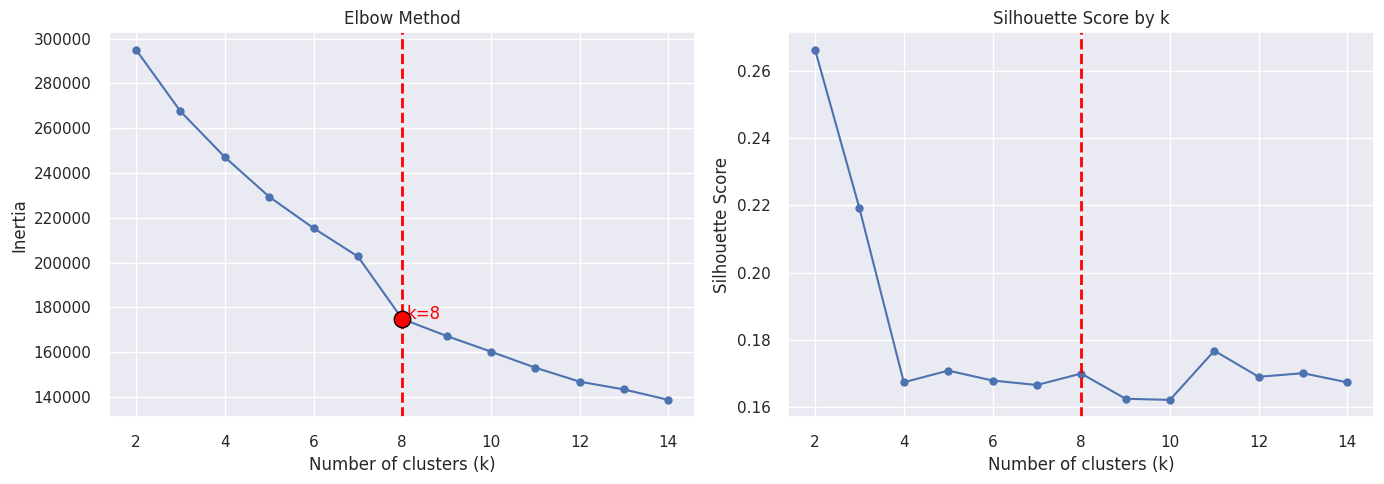

In [8]:
inertias = []        # To store inertia values for different k
sil_scores = []      # To store silhouette scores for different k
K_range = list(range(2, 15))  # Range of k values to test

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto") # Initialize KMeans
    labels = km.fit_predict(X_scaled) # Fit and predict clusters
    
    inertias.append(km.inertia_) # Store inertia
    sil_scores.append(silhouette_score(X_scaled, labels)) # Store silhouette score

# Detect elbow point
kl = KneeLocator(
    K_range, 
    inertias,
    curve="convex",
    direction="decreasing"
) # Initialize KneeLocator

best_k = kl.knee# Get the elbow point (best k)
print("Detected elbow (best K):", best_k) # Print best k

plt.figure(figsize=(14,5)) # Create a figure for plots

# ---- (1) Elbow Method ----
plt.subplot(1,2,1) # Elbow plot
plt.plot(K_range, inertias, marker="o") # Plot inertia vs k
plt.title("Elbow Method") # Plot title
plt.xlabel("Number of clusters (k)") # X-axis label
plt.ylabel("Inertia") # Y-axis label 

# Mark elbow point ONLY on elbow plot
if best_k is not None:
    elbow_y = inertias[K_range.index(best_k)] # Y value at elbow
    plt.scatter(best_k, elbow_y, 
                color='red', s=140, edgecolor='black', zorder=5) # Highlight elbow point
    plt.axvline(best_k, color='red', linestyle='--', linewidth=2) # Vertical line at elbow
    plt.text(best_k + 0.1, elbow_y, f"k={best_k}", color="red") # Annotate elbow point

# ---- (2) Silhouette Scores ----
plt.subplot(1,2,2) # Silhouette score plot
plt.plot(K_range, sil_scores, marker="o")  # Plot silhouette score vs k
plt.title("Silhouette Score by k") # Plot title
plt.xlabel("Number of clusters (k)") # X-axis label
plt.ylabel("Silhouette Score") # Y-axis label

# Mark best_k also on silhouette plot (vertical line only)
if best_k is not None:
    plt.axvline(best_k, color="red", linestyle="--", linewidth=2) # Vertical line at best k

plt.tight_layout() # Adjust layout
plt.savefig(FIGURES_PATH / "k_selection_elbow_silhouette.png") # Save figure
plt.show() # Display plot

### Fit Final K-Means Model

In [9]:
k = best_k if best_k is not None else 8  # Use best_k if detected, else default to 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto") # Initialize KMeans with best k
cluster_labels = kmeans.fit_predict(X_scaled) # Fit and predict clusters

df_clustered = df.loc[df_cluster.index].copy() # Create a copy of the original dataframe for clustered data
df_clustered["cluster"] = cluster_labels # Assign cluster labels
df_clustered["cluster"] = df_clustered["cluster"].astype("category") # Convert cluster labels to categorical type
df_clustered.head() # Display first few rows of clustered dataframe

,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,...,pm25_lag_12h,pm25_lag_24h,pm25_roll_3h_mean,pm25_roll_6h_mean,pm25_roll_12h_mean,pm25_roll_24h_mean,dew_point_spread,temp_pres_interaction,rain_binary,cluster
94761,2016-04-18 09:00:00,2016,4,18,9,10.0,14.3,1004.6,-7.2,0.0,...,9.0,11.0,13.666667,12.333333,10.750000,8.875000,21.5,14365.78,0,2
295101,2016-02-13 21:00:00,2016,2,13,21,6.0,-3.4,1027.3,-20.7,0.0,...,18.0,195.0,7.333333,6.833333,6.333333,22.666667,17.3,-3492.82,0,6
187229,2015-05-01 05:00:00,2015,5,1,5,158.0,19.2,1000.3,14.2,0.0,...,68.0,145.0,144.000000,124.333333,103.416667,116.041667,5.0,19205.76,0,3
146611,2014-07-14 19:00:00,2014,7,14,19,36.0,30.0,995.8,15.3,0.0,...,16.0,23.0,33.666667,32.666667,26.416667,26.750000,14.7,29874.00,0,7
398054,2016-05-07 14:00:00,2016,5,7,14,3.0,25.9,1012.8,-6.9,0.0,...,19.0,9.0,12.000000,15.833333,15.833333,16.333333,32.8,26231.52,0,2


### Cluster Profiles

In [10]:
cluster_summary = (
    df_clustered
    .groupby("cluster", observed=False)[["pm25", "temperature", "dew_point", "pressure", "rain", "wind_speed"]]
    .mean()
    .round(2)
)

cluster_summary

,pm25,temperature,dew_point,pressure,rain,wind_speed
cluster,,,,,,
0,262.16,4.24,-1.06,1015.79,0.00,1.01
1,67.66,15.17,7.82,1013.30,0.05,1.27
2,75.35,14.32,-0.05,1008.60,0.03,1.79
3,67.02,22.84,17.84,1000.26,0.09,1.06
4,68.49,21.41,20.40,999.29,15.38,2.39
5,57.95,-0.51,-12.61,1022.21,0.01,1.38
6,23.03,7.10,-14.63,1018.41,0.00,4.33
7,66.13,28.34,15.46,999.49,0.06,2.09


### PM2.5 Distribution by Cluster

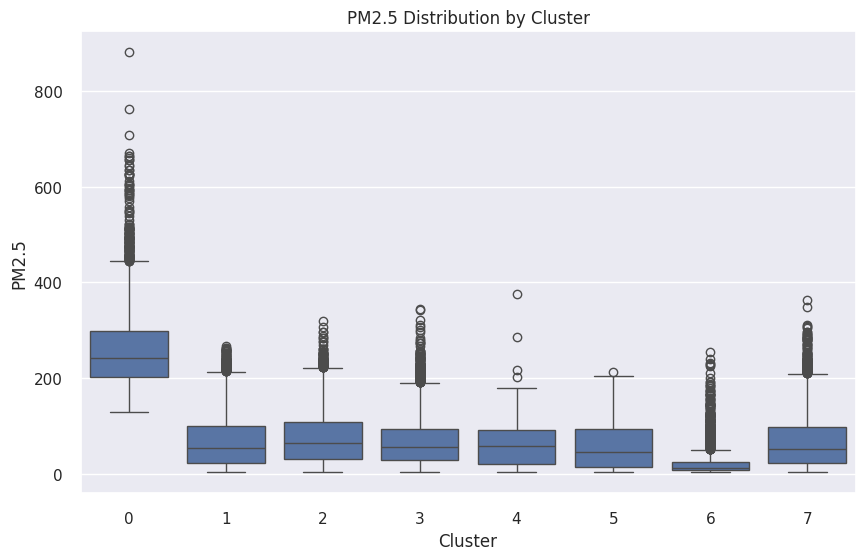

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_clustered, x="cluster", y="pm25")
plt.title("PM2.5 Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("PM2.5")
plt.savefig(FIGURES_PATH / "pm25_by_cluster.png")
plt.show()

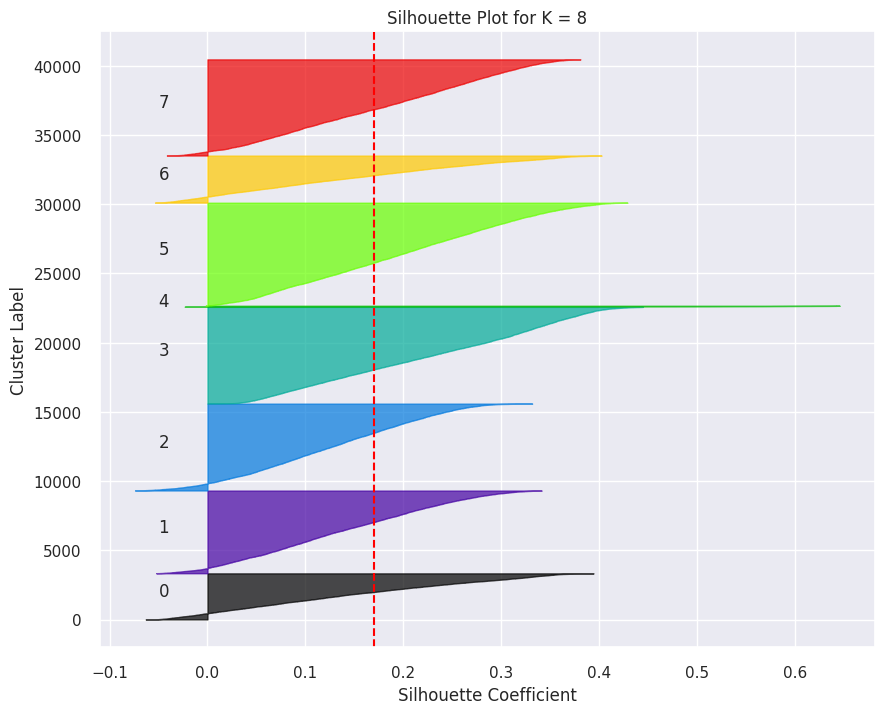

In [12]:
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init="auto") # final KMeans model
cluster_labels = kmeans_final.fit_predict(X_scaled) # fit final model
silhouette_vals = silhouette_samples(X_scaled, cluster_labels) # compute silhouette scores

y_lower = 10 # initial y position for silhouette plot
plt.figure(figsize=(10,8)) # create figure for silhouette plot

# Plot silhouette scores for each cluster
for i in range(k): 
    ith_cluster_vals = silhouette_vals[cluster_labels == i] # silhouette scores for cluster i
    ith_cluster_vals.sort() # sort silhouette scores

    size = ith_cluster_vals.shape[0] # number of points in cluster i
    y_upper = y_lower + size # upper y position for cluster i

    color = cm.nipy_spectral(float(i) / k) # color for cluster i
    plt.fill_betweenx(np.arange(y_lower, y_upper), # plot silhouette scores
                      0, ith_cluster_vals, 
                      facecolor=color, edgecolor=color, alpha=0.7) # fill area

    plt.text(-0.05, y_lower + 0.5 * size, str(i)) # label cluster
    y_lower = y_upper + 10  # spacing between clusters

plt.title(f"Silhouette Plot for K = {best_k}") # plot title
plt.xlabel("Silhouette Coefficient") # x-axis label
plt.ylabel("Cluster Label") # y-axis label
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")  # average silhouette line
plt.savefig(FIGURES_PATH / "silhouette_plot.png") # save figure
plt.show()  # display plot

In [13]:
df_clustered["cluster"].value_counts().sort_index()

cluster
0    3324
1    5969
2    6270
3    6980
4      70
5    7432
6    3392
7    6941
Name: count, dtype: int64

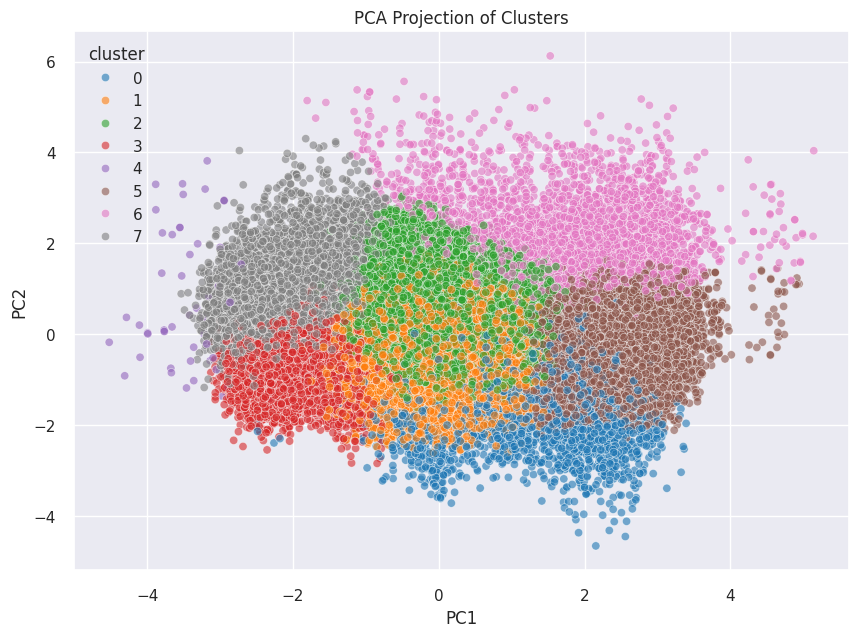

In [14]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(
    x=pca_coords[:,0], 
    y=pca_coords[:,1],
    hue=df_clustered["cluster"],
    palette="tab10",
    alpha=0.6
)
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(FIGURES_PATH / "pca_clusters.png")
plt.show()

#### Observations

- The silhouette plot indicates that clusters 0 and 1 are well-separated, with consistently positive scores.
- Cluster 2 shows more variability, suggesting it contains transitional pollution–weather states.
- No silhouette values fall strongly into the negative range, which confirms that the chosen K provides a reasonable separation.
- The PM2.5 distribution plot reveals that one cluster corresponds to high-pollution events, one to moderate levels, and one to cleaner atmospheric conditions.
- Cluster profiles show clear meteorological differences, indicating that clustering captures meaningful atmospheric regimes.



#### Justification

The combination of inertia, silhouette score, and cluster interpretability supports the chosen number of clusters. 
Although the elbow was not pronounced (typical for environmental data), the silhouette structure 
and distinct cluster profiles indicate that K-Means successfully identifies meaningful patterns 
in the PM2.5–meteorology relationship. This demonstrates the validity of using unsupervised learning 
to segment atmospheric conditions into stable regimes.


## Save Models

In [15]:
joblib.dump(kmeans, MODELS_PATH / "kmeans_cluster_model.joblib", compress=3)
joblib.dump(scaler, MODELS_PATH / "scaler_cluster.joblib", compress=3)

print("Saved clustering model and scaler.")

Saved clustering model and scaler.


### Save Derived Dataset, silhouette values and PCA points for Dashboard

In [16]:
pca_df = pd.DataFrame({
    "pc1": pca_coords[:, 0],
    "pc2": pca_coords[:, 1],
    "cluster": df_clustered["cluster"].values,
    "pm25": df_clustered["pm25"].values
}) # Create dataframe for PCA coordinates
pca_df.to_csv(DERIVED_DATA_PATH / "pca_coords.csv", index=False) # Save PCA coordinates

print("Saved PCA coordinates.")

Saved PCA coordinates.


In [17]:
sil_df = pd.DataFrame({
    "silhouette": silhouette_vals,
    "cluster": df_clustered["cluster"].values
}) # Create dataframe for silhouette values
sil_df.to_csv(DERIVED_DATA_PATH / "silhouette_values.csv", index=False) # Save silhouette values

print("Saved silhouette values.")

Saved silhouette values.


In [18]:
df_clustered.to_parquet(
    DERIVED_DATA_PATH / "beijing_clustered.parquet",
    index=False
)# Save clustered dataframe

print("Saved sample dataframe.")

Saved sample dataframe.


## Summary – Clustering & Pattern Discovery

Clustering revealed distinct PM2.5–meteorology regimes that complement the supervised models. 
Identified clusters show clear differences in pollution levels, meteorological conditions, 
and cyclical patterns, demonstrating that unsupervised learning can uncover environmental 
structures not visible through traditional regression-based approaches.

These insights can enhance modelling (e.g., cluster-aware forecasting), guide feature engineering, 
and support interpretability in downstream analysis.


---

### AI Assistance Note

Some narrative text and minor formatting or wording improvements in this notebook were supported by AI-assisted tools (ChatGPT for documentation clarity, Copilot for small routine code suggestions, and Grammarly for proofreading). All analysis, code logic, feature engineering, modelling, and interpretations were independently created by the author.